In [8]:
import sys
sys.path.append('../python') #Path to load WI_Solver_Utils.py
import WI_Solver_utils
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import trange
from WI_Solver_utils import InflatonModel, Background, Perturbations, Growth_factor
matplotlib.rcParams.update({'errorbar.capsize': 2})
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

def format_fit_pars(pars, mode='complex'):
    global formatted_pars
    if mode=='complex':
        formatted_pars=[r'$b_1=',r'$b_2=',r'$b_3=',r'$b_4=',r'$b_5=',r'$b_6=',r'$a_1=,',r'$a_2=',r'$a_3=',r'$a_4=',r'$a_5=',r'$a_6=']
    if mode=='simple':
        formatted_pars=[r'$\alpha=',r'$\beta=',r'$A=',r'$B=']
    for i in range(len(pars)):
        pv=pars[i]
        exp = math.floor(math.log10(abs(pv))) # automatically detect the value of c
        if (exp>=1) or (exp<=-2):
            formatted_pv = "{:.2f}⋅10^{{{}}}".format(pv / 10**exp, exp)
        else:
            formatted_pv = "{:.2f}".format(pv)
        #Add formatted_pv to the ith element of formatted_pars, before the last $ sign:
        formatted_pars[i]=formatted_pars[i]+formatted_pv+'$'
    #Return as a single string of two columns with commas between the elements:
    return ', '.join(formatted_pars[:len(pars)//2])+'\n '+', '.join(formatted_pars[len(pars)//2:])


In [2]:
####################################################################
#   Define tau array over which we solved for the perturbations:   #
####################################################################
"""Recall: \tau=\ln(z)=\ln(k/(aH))"""

tau_ini = 6
tau_end = -1
N = 100000
dtau = (tau_end - tau_ini) / N # DT is a negative quantity as expected since tau is decreasing over time
taus = np.linspace(tau_ini, tau_end, N)


#################################
#   Define Global Parameters:   #
#################################

Mpl = 1 # Everything is in Plank units M_{pl}
g = 228.27  # SUSY relativistic degrees of freedom
a1 = np.pi**2/30*g

Neinflation=[40,60,80] #Number of e-folds of inflation
Nruns=1024 #How many runs did we average over to compute the perturbations
MPs_bool='wo' #without metric perturbations
epsH_etaH_bool='wo' #negligible epsH and etaH

cm_cases=[[0,0],[0,-1],[3,2],[3,0],[1,0],[-1,0],[-1,2]]


In [3]:
#######################################################################
#   Define the type of inflaton potential and its main parammeters:   #
#######################################################################

potential_type='quartic'

lv = 10**(-14)  # value of lambda

Model = InflatonModel('monomial', [lv, 4], g, a1, Mpl)


################################################
#   Initial conditions on \phi0 and Q array:   #
################################################

"""
Note here we load previously computed initial conditions that guarantee N_e= Neinflation + 8 efolds of inflation.
To see how these were computed, check out the notebook "ICs_ph0.ipynb"
"""

Q0s,ph0s=[],[]
for i in range(len(Neinflation)):
    ICs_Q0_ph0=np.loadtxt('../ICS_ph0-Q0s/ICS_ph0-Q0s_'+potential_type+'_Ne'+str(int(Neinflation[i]))+'.txt')
    Q0s.append(ICs_Q0_ph0[:,0])
    ph0s.append(ICs_Q0_ph0[:,1])
    del ICs_Q0_ph0
Q0s=np.array(Q0s)
ph0s=np.array(ph0s)


########################################################################
#   Compute the Analytic approximation of the Power spectrum for c=0   #
########################################################################

R2_analytic=[]
for j in range(len(Neinflation)):
    R2_Ne=np.zeros(len(Q0s[j]))
    for i in trange(len(Q0s[j])):
        Bg=Background(Model,ph0s[j,i],Q0s[j,i])
        R2_Ne[i]=Bg.analytic_power_spectrum(int(Neinflation[j]+11), 10**(6), taus, Neinflation[j])
        del Bg
    R2_analytic.append(R2_Ne)
    del R2_Ne

100%|███████████████████████████████████████████| 52/52 [01:31<00:00,  1.76s/it]


In [7]:
R2m_list, R2std_list=[],[]
for j in range(len(Neinflation)):
    R2m_Ne, R2std_Ne=[],[]
    for i in trange(len(cm_cases)):
        cval=cm_cases[i][0]
        mval=cm_cases[i][1]
        _,R2m,R2std=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(MPs_bool)+'MPs_'+str(epsH_etaH_bool)+'epsH-etaH_'+potential_type+'_c'+str(cval)+'m'+str(mval)+'_n'+str(int(N))+'_Nr'+str(int(Nruns))+'_Ne'+str(int(Neinflation[j]))+'.txt')
        R2m_Ne.append(R2m)
        R2std_Ne.append(R2std)
        del R2m, R2std
    R2m_list.append(R2m_Ne)
    R2std_list.append(R2std_Ne)
    del R2m_Ne, R2std_Ne
R2m_list=np.array(R2m_list)
R2std_list=np.array(R2std_list)
                           

100%|███████████████████████████████████████████| 7/7 [00:00<00:00, 2593.65it/s]


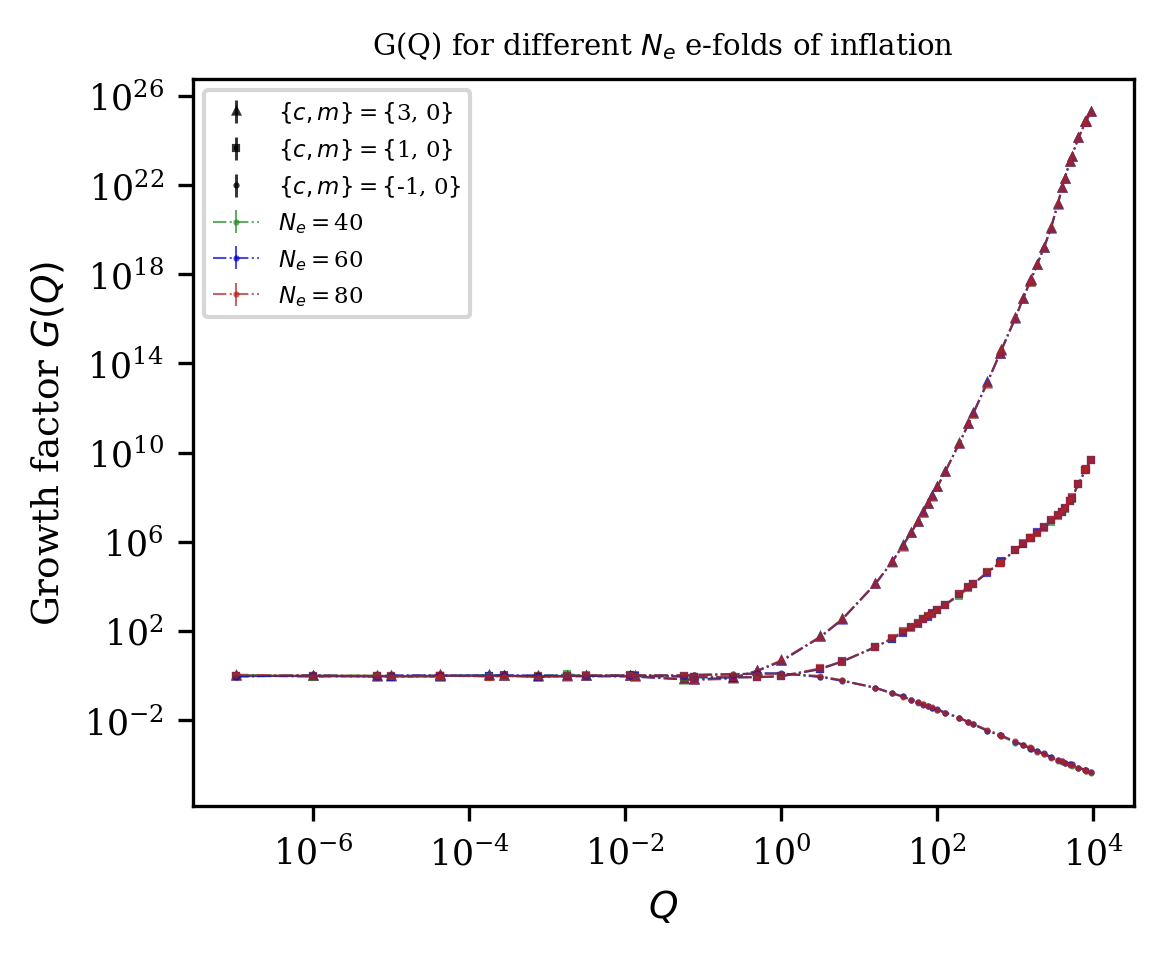

In [35]:
cm_index=3
#Make Figure where I plot the data and the fit:
fig1=plt.figure(figsize=(4.5,3.5),dpi=300)
gs1 = GridSpec(20,20,figure=fig1)
ax1 = fig1.add_subplot(gs1[1:-1,1:-1])


##############################
# Useful for general legend: #
##############################
Ne_cols_data=['forestgreen','mediumblue','firebrick']
Ne_cols_fits=['lime','cyan','salmon']
marker_cm=['^','s','.']
ax1.set_xlabel("$Q$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_ylabel("Growth factor $G(Q)$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_title(r"G(Q) for different $N_e$ e-folds of inflation",fontdict={'fontsize':7,'family':'serif'})

while cm_index in range(6):
    ax1.errorbar(np.NaN, np.NaN, yerr=np.NaN,c='k', label="$\{c,m\}=\{$"+str(int(cm_cases[cm_index][0]))+', '+str(int(cm_cases[cm_index][1]))+'$\}$', marker=marker_cm[cm_index-3],ls='none',markersize=1,linewidth=0.7,alpha=0.8)
    for j in range(len(Neinflation)):
        Gf=Growth_factor(Model,Q0s[j],ph0s[j],R2m_list[j][cm_index],R2std_list[j][cm_index],Nruns,int(Neinflation[j]+11),10**(6),taus,Neinflation[j],cm_cases[cm_index][0],cm_cases[cm_index][1])
        _,_,GQ_sig,GQ_err=Gf.growth_factor_fit(method='simple',output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic[j])
        if cm_index==5:
            ax1.errorbar(Q0s[j],GQ_sig,yerr=GQ_err,c=Ne_cols_data[j],marker=marker_cm[cm_index-3],ls='-.',markersize=1,linewidth=0.5,label='$N_e=$'+str(int(Neinflation[j])),alpha=0.7)
        else:
            ax1.errorbar(Q0s[j],GQ_sig,yerr=GQ_err,c=Ne_cols_data[j],marker=marker_cm[cm_index-3],ls='-.',markersize=1,linewidth=0.5, alpha=.7)            
        del Gf,GQ_sig,GQ_err
    cm_index+=1

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(prop={'family':'serif','size':5.5},framealpha=0.8)
plt.show()